In [1]:
#MODIFIED LOSS
#MIXUP
#image with padding 1

%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os 
import fastai2
from fastai2.vision.all import *
from sklearn.metrics import recall_score
print(fastai2.__version__)
from sklearn.model_selection import StratifiedKFold, KFold
from joblib import load, dump
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import pretrainedmodels

0.0.10


In [2]:
FOLD = 1
NAME = 'FA_10_10'
SUFFIX =f'RESNEXT_SIMPLE_AUG_MIXUP_{FOLD}'
PATH = Path('../../../bengaliai')
SZ = 128
BS = 512
SEED = 2019
N_FOLDS = 6
TRAIN_IMG = PATH/'img_trn_orig'
LABELS = PATH/'train.csv'

In [3]:
def multi_strt_split(x, y, n_folds=N_FOLDS, random_seed = 42, path=Path('')):  
    try: 
        val_name = load('val_idx.joblib')
    except:
        skf = MultilabelStratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
        val_name = [(val_idx, trn_idx) for trn_idx, val_idx in skf.split(x, y)]
        dump(val_name,'val_idx.joblib')
    return val_name

In [4]:
df = pd.read_csv(str(LABELS))
nunique = list(df.nunique())[1:-1]

In [5]:
val_idx = multi_strt_split(df['image_id'], df[df.columns[1:-1]])[FOLD]

In [6]:
bengali = DataBlock(blocks=(ImageBlock(cls=PILImageBW), *(3*[CategoryBlock])),
                    getters=[ColReader('image_id', pref=TRAIN_IMG, suff='.png'),   # input
                             ColReader('grapheme_root'),                       # label 1
                             ColReader('vowel_diacritic'),                     # label 2
                             ColReader('consonant_diacritic')],                # label 3
                    splitter=IndexSplitter(val_idx[0]))

In [7]:
tfms = aug_transforms(do_flip=False, size=SZ)
tfms += [Normalize.from_stats([0.0692], [0.2051])]
dls = bengali.dataloaders(df, bs=BS, batch_tfms=tfms)
dls.n_inp = 1 

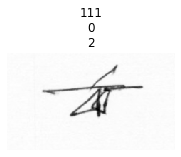

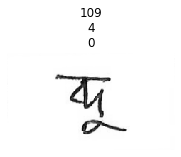

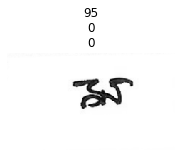

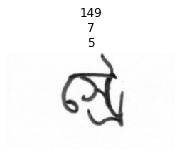

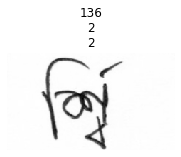

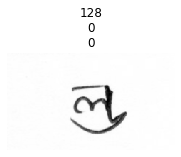

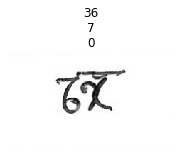

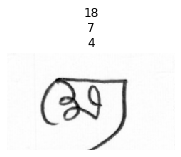

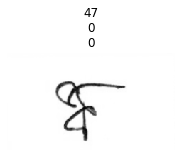

In [8]:
dls.show_batch(figsize=(3,3))

In [9]:
class Head(Module):
    def __init__(self, nc, n, ps=0.5):
        self.fc = nn.Sequential(*[AdaptiveConcatPool2d(), nn.ReLU(inplace=True), Flatten(),
             LinBnDrop(nc*2, 512, True, ps, nn.ReLU(inplace=True)),
             LinBnDrop(512, n, True, ps)])
        self._init_weight()
        
    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1.0)
                m.bias.data.zero_()
        
    def forward(self, x):
        return self.fc(x)

class BengaliModel(Module):
    def __init__(self, arch, nc=2048, n=dls.c, pre=True):
        self.body = arch
        self.heads = nn.ModuleList([Head(nc, c) for c in n])
        
    def forward(self, x):    
        x = self.body(x)
        return [f(x) for f in self.heads]

In [10]:
# Loss function
class Loss_combine(Module):
    def __init__(self, func=F.cross_entropy, weights=[2, 1, 1]):
        self.func, self.w = func, weights

    def forward(self, xs, *ys, reduction='mean'):
        for i, w, x, y in zip(range(len(xs)), self.w, xs, ys):
            if i == 0: loss = w*self.func(x, y, reduction=reduction) 
            else: loss += w*self.func(x, y, reduction=reduction) 
        return loss

In [11]:
arch = pretrainedmodels.se_resnext50_32x4d(num_classes=1000)
arch=list(arch.children())[:-2]
w = arch[0][0].weight
arch[0][0] = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
arch[0][0].weight = nn.Parameter(torch.mean(w, dim=1, keepdim=True))
arch = nn.Sequential(*arch)

In [12]:
arch = BengaliModel(arch=arch)

In [13]:
# MixUp
from torch.distributions.beta import Beta
def NoLoss(*o): pass
class MixUp(Callback):
    run_after,run_valid = [Normalize],False
    def __init__(self, alpha=0.4): 
        self.distrib = Beta(tensor(alpha), tensor(alpha))
        
    def begin_fit(self):
        self.loss_func0 = self.learn.loss_func
        
    def begin_batch(self):
        self.learn.loss_func = NoLoss
        lam = self.distrib.sample((self.y[0].size(0),)).squeeze().to(self.x[0].device)
        lam = torch.stack([lam, 1-lam], 1)
        self.lam = lam.max(1)[0]
        shuffle = torch.randperm(self.y[0].size(0)).to(self.x.device)
        xb1 = tuple(L(self.xb).itemgot(shuffle))
        yb1 = tuple([self.yb[i][shuffle] for i in range(len(self.yb))])
        nx_dims = len(self.x.size())
        self.learn.xb = tuple(L(xb1,self.xb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=nx_dims-1)))
        self.learn.yb = yb1,self.yb
        
    def after_loss(self):
        loss0 = self.loss_func0(self.learn.pred, *self.learn.yb[0], reduction='none')
        loss1 = self.loss_func0(self.learn.pred, *self.learn.yb[1], reduction='none')
        self.learn.loss = torch.lerp(loss0, loss1, self.lam).mean()
        self.learn.loss_func = self.loss_func0

In [14]:
# Metrics
class RecallPartial(Metric):
    # based on AccumMetric
    "Stores predictions and targets on CPU in accumulate to perform final calculations with `func`."
    def __init__(self, a=0, **kwargs):
        self.func = partial(recall_score, average='macro', zero_division=0)
        self.a = a

    def reset(self): self.targs,self.preds = [],[]

    def accumulate(self, learn):
        pred = learn.pred[self.a].argmax(dim=-1)
        targ = learn.y[self.a]
        pred,targ = to_detach(pred),to_detach(targ)
        pred,targ = flatten_check(pred,targ)
        self.preds.append(pred)
        self.targs.append(targ)

    @property
    def value(self):
        if len(self.preds) == 0: return
        preds,targs = torch.cat(self.preds),torch.cat(self.targs)
        return self.func(targs, preds)

    @property
    def name(self): return df.columns[self.a+1]
    
class RecallCombine(Metric):
    def accumulate(self, learn):
        scores = [learn.metrics[i].value for i in range(3)]
        self.combine = np.average(scores, weights=[2,1,1])

    @property
    def value(self):
        return self.combine

In [ ]:
# Create learner
learn = Learner(dls, arch, loss_func=Loss_combine(), cbs=[MixUp(),
                                                          CSVLogger(),
                                                          SaveModelCallback(monitor = 'recall_combine', fname=f'{NAME}_{SUFFIX}')],
                metrics=[RecallPartial(a=i) for i in range(len(dls.c))] + [RecallCombine()])

learn.model = nn.DataParallel(learn.model)
learn.opt_func = RAdam
learn.unfreeze()
learn.fit_flat_cos(n_epoch=80, lr=1e-3, pct_start=0.7, div_final = 1000, wd=1e-2)

epoch,train_loss,valid_loss,grapheme_root,vowel_diacritic,consonant_diacritic,recall_combine,time
0,4.347317,1.273939,0.825792,0.935029,0.895655,0.870567,05:23
1,3.639751,0.790542,0.897355,0.964083,0.954834,0.928407,05:06
2,3.278533,0.618285,0.933593,0.975155,0.971841,0.953546,05:06
3,2.989350,0.531468,0.941512,0.973670,0.962822,0.954879,05:06
4,2.821507,0.515677,0.938773,0.981270,0.967820,0.956659,05:05
5,2.652357,0.500780,0.950816,0.979814,0.972657,0.963526,05:06
6,2.532436,0.453586,0.948951,0.981530,0.968697,0.962032,05:06
7,2.429950,0.427134,0.953217,0.979325,0.973120,0.964720,05:06
8,2.343717,0.412961,0.951279,0.984181,0.977968,0.966177,05:06
9,2.274936,0.409039,0.957783,0.981947,0.974488,0.968000,05:05


In [ ]:
!sudo shutdown